## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [11]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

In [12]:

%%time
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

#dataset_name = 'JEC'
#dataset_name = 'WT'
#dataset_name = 'HALE'


model_names = {0:'Free-IWT',1:'Free-IWT,IWB',2:'Free-IWT,IWB,Rot',3:'Free-IWT,IWB,Rot,Stall',
               4:'Free-IWT,IWB,Rot,Stall,Drag',5:'Free-IWT,Rot,Stall,Drag',
               6:'Free-IWT,IWB,Rot,Stall,Drag,Lin0',7:'Free-IWT,Rot,Stall,Drag,Lin0'}

model_names = {0:'Full Model',1:'No ZFR',2:'No Force Rot',3:'No Stall',
               4:'SAM',5:'LIN',6:'Full Model, lin 0',7:'No ZFR, Lin 0'}



ls = []
#for i in range(8):
#for i in [8,9,10,11,12]:
for i in [6]:
    for j in ["JEC","WT","HALE"]:
        try:
            dat = pd.read_pickle(f'Eigen_{b_modes}B{t_modes}T-M{i}_{j}.pkl')
            dat['Model'] = i
            dat['Config'] = j
            ls.append(dat)
        except:
            pass
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Twist'] = pd.Categorical(np.rad2deg(flutdf['tau_1']))
flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])

flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
flutdf['Locked'] = pd.Categorical((flutdf['k_fwt']>0).map({True:"Locked",False:"Free"}))

CPU times: user 1.36 s, sys: 193 ms, total: 1.55 s
Wall time: 1.55 s


### Load all test data into a singe dataframe

In [13]:
def GetReducedDataSet(flutdf,model_num,Config = ["JEC"],Twist = [0],Flare=25,AoA=0,ratio_FWT=20,FWT_mass = 100,c_dmax = 0,Vmin = 1,Vmax = 140,Modes=None,Stable=None,Locked = ["Free"]):
    data = flutdf.copy()
    data = data[cpo.SeriesFilter(data['Model'],model_num)]
    data = data[cpo.SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[cpo.SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[cpo.SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[cpo.SeriesFilter(data['Mode'],Modes)]
    data = data[cpo.SeriesFilter(data['Stable'],Stable)]
    data = data[cpo.SeriesFilter(data['Config'],Config)]
    data = data[cpo.SeriesFilter(data['Twist'],Twist)]
    data = data[data['V']<=Vmax]
    data = data[data['V']>=Vmin]
    
    #data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    data = data[cpo.SeriesFilter(data['c_dmax'],c_dmax)]
    data = data[cpo.SeriesFilter(data['Locked'],Locked)]
    return data

In [14]:
d = GetReducedDataSet(flutdf,[5])

## Compare Non-Linear Models

[]


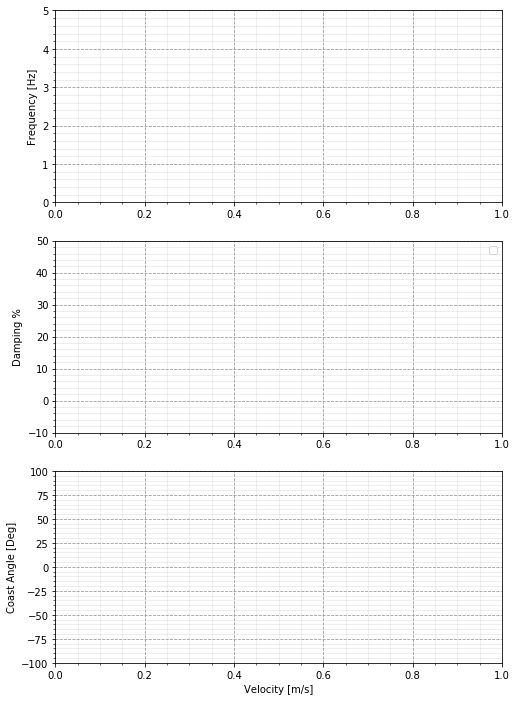

In [15]:
fig, axes = plt.subplots(3,1,figsize=(8,12))    

Tests = [8,9,10,11,12]
hue = 'Model'
modes = None
modes = [1,2,3]
data = GetReducedDataSet(flutdf,Tests,Config = ["JEC"],ratio_FWT=20,FWT_mass = 100,c_dmax = 0,
                         Flare = 17.5,AoA = [5],Modes=modes,Stable=None)

cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',ax = axes[0])
cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])
cpo.CoastDeltaPlot(data,hue, axes[2],Delta = False)
print(np.unique(data['c_dmax']))
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,40))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,5))
axes[1].set(ylim=(-10,50))    
axes[2].set(ylim=(-100,100))  

#axes[1].set(xlim=(60,70))   
axes[1].set(ylim=(-10,50))    

#PlotModes(data,'Test',axes[:])
#axes[1].legend([model_names[i] for i in Tests])
axes[1].legend([30,15,0,-15,-30])
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

## Parameter Sweeps

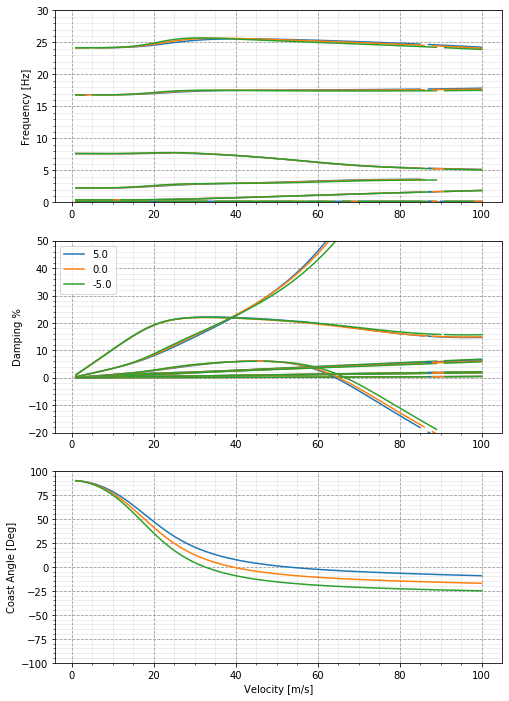

In [16]:
fig, axes = plt.subplots(3,1,figsize=(8,12))    

Tests = [6]
#hue = 'AoA [Deg]'
hue = 'Twist'
#hue = 'Flare Angle [Deg]'
#hue = 'FWT Mass [%]'
#hue = 'c_dmax'
#hue = 'Locked'

data = GetReducedDataSet(flutdf,Tests,
                         Config = ["JEC"],
                         ratio_FWT=20,
                         FWT_mass = None if hue == 'FWT Mass [%]' else [100],
                         c_dmax = [0,1] if hue == 'c_dmax' else [1],
                         Flare = None if hue == 'Flare Angle [Deg]' else [17.5],
                         AoA = None if hue == 'AoA [Deg]' else [5],
                         Twist = None if hue == 'Twist' else [0],
                         Modes=None,
                         Stable=None,
                         Locked =None if hue == 'Locked' else ["Free"])

cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Frequency',ax = axes[0])
cpo.PlotLines(data,x = 'V',Modes = flutdf['Mode'].cat.categories,hue = hue,y = 'Damping [%]',ax = axes[1])
cpo.CoastDeltaPlot(data,hue, axes[2],Delta = False)
for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,40))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,30))
axes[1].set(ylim=(-20,50))    
axes[2].set(ylim=(-100,100))  


#PlotModes(data,'Test',axes[:])
#axes[1].legend([model_names[i] for i in Tests])
axes[1].legend(data[hue].unique())
#axes[1].legend(flutdf['AoA [Deg]'].cat.categories)
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)